# Проект "Телеком"

# План проекта:

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Цель проекта: Создать модель, колторая будет пронозировать отток клиентов, чтобы вычислять таких абонентов и за счет различных мотиваций пытаться оставить их в компании

# Содержание

    1 Загрузка и анализ данных
        1.1 загрузка данных, объединение таблиц
        1.2 Предобработка данных
        1.3 исследовательский анализ данных
        1.4 исследование корреляции признаков
    2 Подготовка данных
        2.1 Выделение целевого признака
        2.2 Создание тренировочного и тестового датасета
    3. Построение моделей
        3.1 Логистическая регрессия
        3.2 Случайный лес
        3.3 Модель градиентного бустинга CatBoost
        3.4 Модель LightGBM
        3.5 Сравнение результатов модели, выбор наилучшей
    4. Тестирование лучшей модели
        4.1 Проверка лучшей модели на тестовой выборке
        4.2 Проверка модели на адекатность
    5. Выводы по проекту
        
        


# 1. Загрузка и анализ данных

Установим необходимы библиотеки

In [1]:
!pip install phik
!pip install lightgbm

     |████████████████████████████████| 679 kB 1.9 MB/s eta 0:00:01


Обновиим библиотеки до последних версий 

In [2]:
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn


In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split
)
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool,cv
import lightgbm as lgb
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

import warnings
warnings.filterwarnings('ignore')

##  1.1 загрузка данных, объединение таблиц

In [4]:
try:
    contract = pd.read_csv('D:/contract.csv')
    personal = pd.read_csv('D:/personal.csv')
    internet = pd.read_csv('D:/internet.csv')
    phone = pd.read_csv('D:/phone.csv')
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')
                        

In [5]:
def data_info(data):
    print(data.info())
    print(data.describe())
    try:
        data.hist(figsize=(10, 15))
    except:
        print('No hist')

Посмотрим информацию о датасете `contract`

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
       MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000


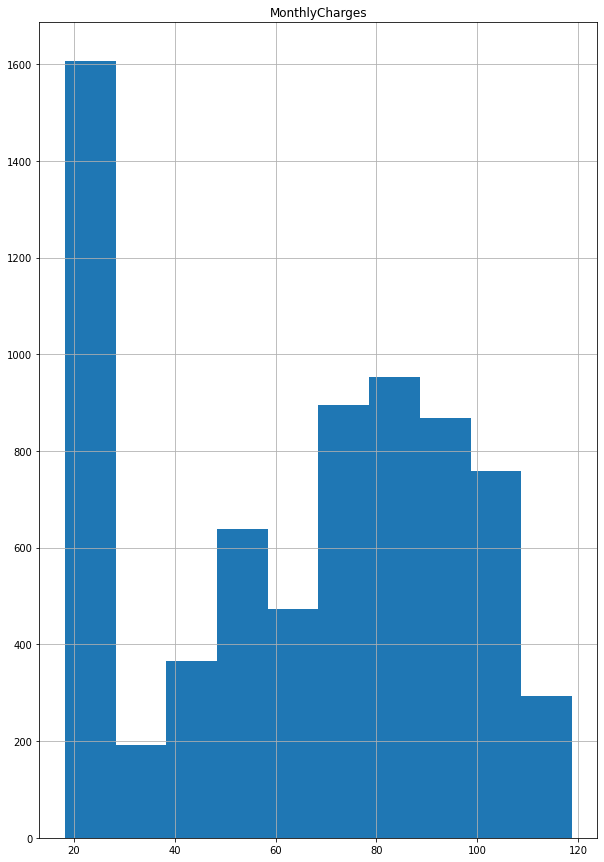

In [6]:
data_info(contract)

Посмотрим информацию о датасете `personal`

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
       SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000


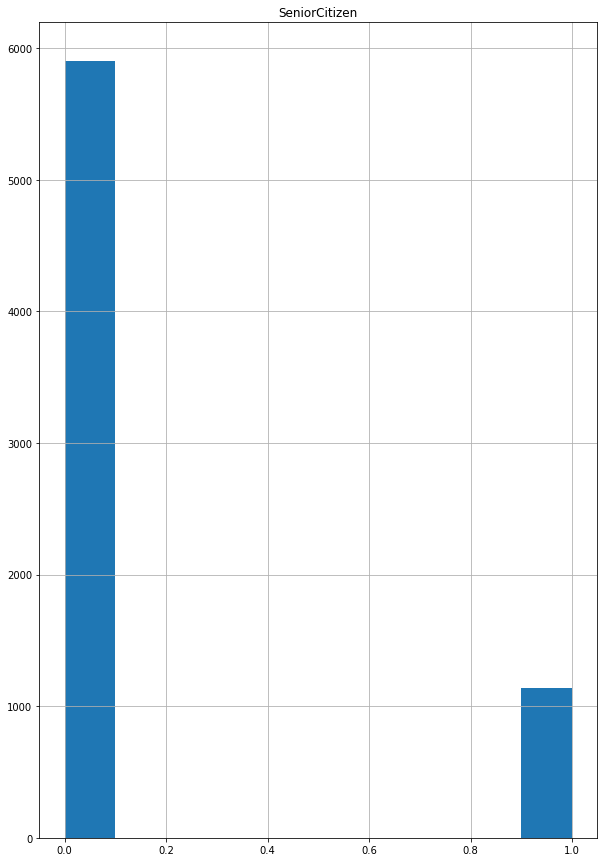

In [7]:
data_info(personal)

Посмотрим информацию о датасете ` internet`

In [8]:
data_info(internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None
        customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     0285-INHLN     Fiber optic             No           No   
freq             1            3096           3498         3088   

       DeviceProtection TechSupport StreamingTV Streamin

Посмотрим информацию о датасете `phone`

In [9]:
data_info(phone)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None
        customerID MultipleLines
count         6361          6361
unique        6361             2
top     6615-NGGZJ            No
freq             1          3390
No hist


По предаврительному анализу мы можем сказать, что у нас присутствует один численный признак, остальные признаки категориальные. Так же в столбце `SeniorCitizen` мы изменим тип данных с int на bool, чтобы он тоже был категориальным

Объединим данные с 4 таблиц в 1 датасет и посмотрим информацию о нем

In [10]:
data=pd.merge(contract, personal, on='customerID', how='left')
data=pd.merge(data,internet, on='customerID', how='left')
data=pd.merge(data,phone, on='customerID', how='left')

In [11]:
data.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5,Female,0,No,No,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,Male,0,No,Yes,Fiber optic,No,Yes,No,No,Yes,No,Yes
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9,Female,0,No,No,DSL,Yes,No,No,No,No,No,NaN
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,Female,0,Yes,No,Fiber optic,No,No,Yes,Yes,Yes,Yes,Yes
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95,Male,0,No,Yes,DSL,Yes,Yes,No,No,No,No,No


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


После того, как мы объеденили ячейки, поле `customer_id` нам больше не нужно, можем его удалить

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


In [14]:
data=data.drop(['customerID'], axis=1)


Приведем имена столбцов к классическому виду

In [15]:
# создадим список с названиеми столбцов в классическом виде
data_column=['begin_date',
             'end_date',
             'type',
             'paper_less_billing',
             'payment_method',
             'monthly_charges',
             'total_charges',
             'gender',
             'senior_citizen',
             'partner',
             'dependents',
             'internet_service',
             'online_security',
             'online_backup',
             'device_protection',
             'tech_support',
             'streaming_tv',
             'streaming_movies',
             'multiple_lines']
data.columns = data_column #передадим этот список нашему датасету

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   begin_date          7043 non-null   object 
 1   end_date            7043 non-null   object 
 2   type                7043 non-null   object 
 3   paper_less_billing  7043 non-null   object 
 4   payment_method      7043 non-null   object 
 5   monthly_charges     7043 non-null   float64
 6   total_charges       7043 non-null   object 
 7   gender              7043 non-null   object 
 8   senior_citizen      7043 non-null   int64  
 9   partner             7043 non-null   object 
 10  dependents          7043 non-null   object 
 11  internet_service    5517 non-null   object 
 12  online_security     5517 non-null   object 
 13  online_backup       5517 non-null   object 
 14  device_protection   5517 non-null   object 
 15  tech_support        5517 non-null   object 
 16  stream

**Мы загрузили данные, объединили их в одну таблицу и привели названия столбцов в калссический вид, теперь можем переходить к предобработке и исследовательскому анализу

## 1.2 Предобработка данных

В столбце `end_date` расположены даты окончания договора. значение 'No' означает, что договор еще не расторгнут. Создадим из этого столбца столбец с целевым признаком `exited` - факт расторжения договора, в который укажем 1, если договоря расторгнут, 0, если договор еще действует

In [17]:
data['exited']=1
for i in range(len(data)):
    if 'No' in data.loc[i,'end_date']:
        data.loc[i, 'exited'] = 0
data.head()

,begin_date,end_date,type,paper_less_billing,payment_method,monthly_charges,total_charges,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,exited
0,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN,0
1,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0
2,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,1
3,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN,0
4,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,1


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   begin_date          7043 non-null   object 
 1   end_date            7043 non-null   object 
 2   type                7043 non-null   object 
 3   paper_less_billing  7043 non-null   object 
 4   payment_method      7043 non-null   object 
 5   monthly_charges     7043 non-null   float64
 6   total_charges       7043 non-null   object 
 7   gender              7043 non-null   object 
 8   senior_citizen      7043 non-null   int64  
 9   partner             7043 non-null   object 
 10  dependents          7043 non-null   object 
 11  internet_service    5517 non-null   object 
 12  online_security     5517 non-null   object 
 13  online_backup       5517 non-null   object 
 14  device_protection   5517 non-null   object 
 15  tech_support        5517 non-null   object 
 16  stream

Теперь из столбцов `begin date` и `end_date` получим количество месяцев, которые действует договор.

In [19]:
# Заемняем значения No на дату получения данных
for i in range(len(data)):
    if 'No' in data.loc[i,'end_date']:
        data.loc[i, 'end_date'] = '2020-02-01'
# Приводим значения столбцов к формату `date`
data['begin_date'] = pd.to_datetime(
    data['begin_date'], format='%Y.%m.%d'
)
data['end_date'] = pd.to_datetime(
    data['end_date'], format='%Y.%m.%d'
)
# добавляем столбец, в котором будет посчитано сколько месяцев абонент пользуется услугами компании
data['week'] = round(((data['end_date']-data['begin_date'])/np.timedelta64(1, 'W')),0)
data['week'] = data['week'].astype(int)

In [20]:
# Удалим столбцы `begin_date` и `end_date`
data=data.drop(['begin_date', 'end_date'], axis=1)

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   type                7043 non-null   object 
 1   paper_less_billing  7043 non-null   object 
 2   payment_method      7043 non-null   object 
 3   monthly_charges     7043 non-null   float64
 4   total_charges       7043 non-null   object 
 5   gender              7043 non-null   object 
 6   senior_citizen      7043 non-null   int64  
 7   partner             7043 non-null   object 
 8   dependents          7043 non-null   object 
 9   internet_service    5517 non-null   object 
 10  online_security     5517 non-null   object 
 11  online_backup       5517 non-null   object 
 12  device_protection   5517 non-null   object 
 13  tech_support        5517 non-null   object 
 14  streaming_tv        5517 non-null   object 
 15  streaming_movies    5517 non-null   object 
 16  multip

В столбце `SeniorCitizen` мы изменим тип данных с int на bool, чтобы он тоже был категориальным

In [22]:
data['senior_citizen'] = data['senior_citizen'].astype(bool)

В столбце `total_charges` указан формат object, скорее всего там присутствуют пустые значения, заменим их на 0

In [23]:
data['total_charges'] = data['total_charges'].apply(lambda x: float(x) if x!=" " else 0)
data['total_charges'] = data['total_charges'].astype(float)

Посмотрим, в каких столбцах есть пропуски

In [24]:
data.isna().sum()

type                     0
paper_less_billing       0
payment_method           0
monthly_charges          0
total_charges            0
gender                   0
senior_citizen           0
partner                  0
dependents               0
internet_service      1526
online_security       1526
online_backup         1526
device_protection     1526
tech_support          1526
streaming_tv          1526
streaming_movies      1526
multiple_lines         682
exited                   0
week                     0
dtype: int64

In [29]:
# Посмотрим уникальные значения столбца internet_service
data['internet_service'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

In [30]:
# Заменим пропуск на 'No'
data['internet_service']=data['internet_service'].fillna('No')
data['internet_service'].unique()

array(['DSL', 'Fiber optic', 'No'], dtype=object)

In [31]:
# Посмотрим уникальные значения столбца online_security
data['online_security'].unique()

array(['No', 'Yes'], dtype=object)

In [32]:
# Заменим пропуск на 'No'
data['online_security']=data['online_security'].fillna('No')
data['online_security'].unique()

array(['No', 'Yes'], dtype=object)

In [33]:
# Посмотрим уникальные значения столбца online_backup
data['online_backup'].unique()

array(['Yes', 'No', nan], dtype=object)

In [34]:
# Заменим пропуск на 'No'
data['online_backup']=data['online_backup'].fillna('No')
data['online_backup'].unique()

array(['Yes', 'No'], dtype=object)

In [35]:
# Посмотрим уникальные значения столбца device_protection
data['device_protection'].unique()

array(['No', 'Yes', nan], dtype=object)

In [36]:
# Заменим пропуск на 'No'
data['device_protection']=data['device_protection'].fillna('No')
data['device_protection'].unique()

array(['No', 'Yes'], dtype=object)

In [37]:
# Посмотрим уникальные значения столбца tech_support
data['tech_support'].unique()

array(['No', 'Yes', nan], dtype=object)

In [38]:
# Заменим пропуск на 'No'
data['tech_support']=data['tech_support'].fillna('No')
data['tech_support'].unique()

array(['No', 'Yes'], dtype=object)

In [39]:
# Посмотрим уникальные значения столбца streaming_tv
data['streaming_tv'].unique()

array(['No', 'Yes', nan], dtype=object)

In [40]:
# Заменим пропуск на 'No'
data['streaming_tv']=data['streaming_tv'].fillna('No')
data['streaming_tv'].unique()

array(['No', 'Yes'], dtype=object)

In [41]:
# Посмотрим уникальные значения столбца streaming_movies
data['streaming_movies'].unique()

array(['No', 'Yes', nan], dtype=object)

In [42]:
data['streaming_movies']=data['streaming_movies'].fillna('No')
data['streaming_movies'].unique()

array(['No', 'Yes'], dtype=object)

In [43]:
# Посмотрим уникальные значения столбца multiple_lines
data['multiple_lines'].unique()

array([nan, 'No', 'Yes'], dtype=object)

In [44]:
data['multiple_lines']=data['multiple_lines'].fillna('No phone')
data['multiple_lines'].unique()

array(['No phone', 'No', 'Yes'], dtype=object)

In [45]:
data.isna().sum()

type                  0
paper_less_billing    0
payment_method        0
monthly_charges       0
total_charges         0
gender                0
senior_citizen        0
partner               0
dependents            0
internet_service      0
online_security       0
online_backup         0
device_protection     0
tech_support          0
streaming_tv          0
streaming_movies      0
multiple_lines        0
exited                0
week                  0
dtype: int64

In [46]:
# Проверим датасет на наличие явных дубликатов
data.duplicated().sum()

22

In [47]:
# Удалим явные дубликаты
data = data.drop_duplicates().reset_index(drop=True) 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7021 entries, 0 to 7020
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   type                7021 non-null   object 
 1   paper_less_billing  7021 non-null   object 
 2   payment_method      7021 non-null   object 
 3   monthly_charges     7021 non-null   float64
 4   total_charges       7021 non-null   float64
 5   gender              7021 non-null   object 
 6   senior_citizen      7021 non-null   bool   
 7   partner             7021 non-null   object 
 8   dependents          7021 non-null   object 
 9   internet_service    7021 non-null   object 
 10  online_security     7021 non-null   object 
 11  online_backup       7021 non-null   object 
 12  device_protection   7021 non-null   object 
 13  tech_support        7021 non-null   object 
 14  streaming_tv        7021 non-null   object 
 15  streaming_movies    7021 non-null   object 
 16  multip

Поменяем порядок в столбцах, чтобы целевой признак был последним

In [48]:
data=data[['type',
             'paper_less_billing',
             'payment_method',
             'gender',
             'senior_citizen',
             'partner',
             'dependents',
             'internet_service',
             'online_security',
             'online_backup',
             'device_protection',
             'tech_support',
             'streaming_tv',
             'streaming_movies',
             'multiple_lines',
            'monthly_charges', 
            'total_charges', 
            'week',
           'exited'
           
    
]]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7021 entries, 0 to 7020
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   type                7021 non-null   object 
 1   paper_less_billing  7021 non-null   object 
 2   payment_method      7021 non-null   object 
 3   gender              7021 non-null   object 
 4   senior_citizen      7021 non-null   bool   
 5   partner             7021 non-null   object 
 6   dependents          7021 non-null   object 
 7   internet_service    7021 non-null   object 
 8   online_security     7021 non-null   object 
 9   online_backup       7021 non-null   object 
 10  device_protection   7021 non-null   object 
 11  tech_support        7021 non-null   object 
 12  streaming_tv        7021 non-null   object 
 13  streaming_movies    7021 non-null   object 
 14  multiple_lines      7021 non-null   object 
 15  monthly_charges     7021 non-null   float64
 16  total_

** Мы выделили целевой признак, обработали данные и теперь готовы к исследжовательскому анализу

## 1.3 исследовательский анализ данных

In [49]:
data.head()

,type,paper_less_billing,payment_method,gender,senior_citizen,partner,dependents,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,multiple_lines,monthly_charges,total_charges,week,exited
0,Month-to-month,Yes,Electronic check,Female,False,Yes,No,DSL,No,Yes,No,No,No,No,No phone,29.85,29.85,4,0
1,One year,No,Mailed check,Male,False,No,No,DSL,Yes,No,Yes,No,No,No,No,56.95,1889.50,148,0
2,Month-to-month,Yes,Mailed check,Male,False,No,No,DSL,Yes,Yes,No,No,No,No,No,53.85,108.15,9,1
3,One year,No,Bank transfer (automatic),Male,False,No,No,DSL,Yes,No,Yes,Yes,No,No,No phone,42.30,1840.75,196,0
4,Month-to-month,Yes,Electronic check,Female,False,No,No,Fiber optic,No,No,No,No,No,No,No,70.70,151.65,9,1


Сначала посмотрим на численные признаки, у нас их два: `monthly_charges` и `month`

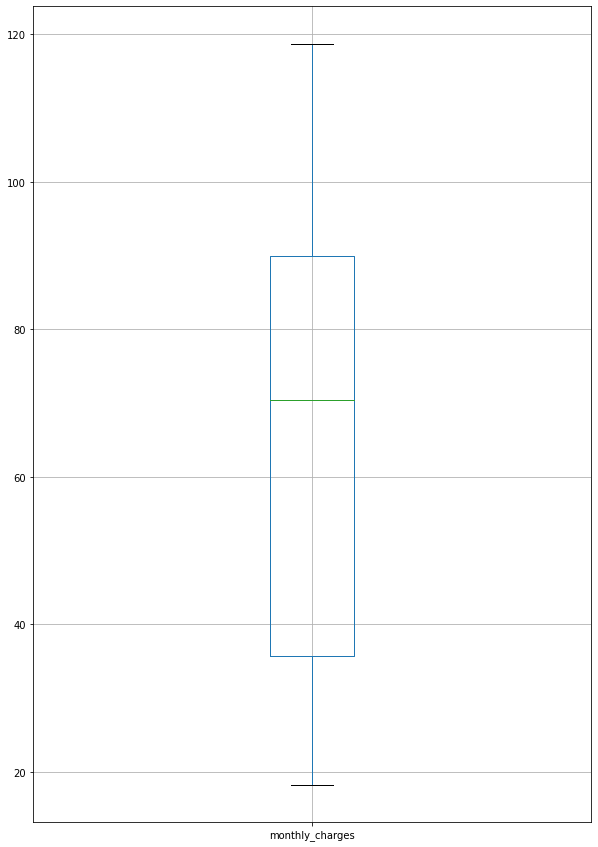

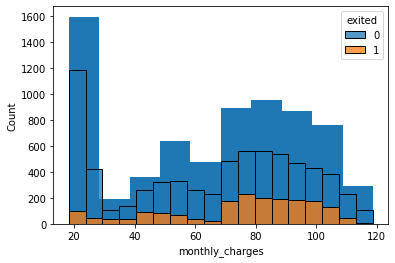

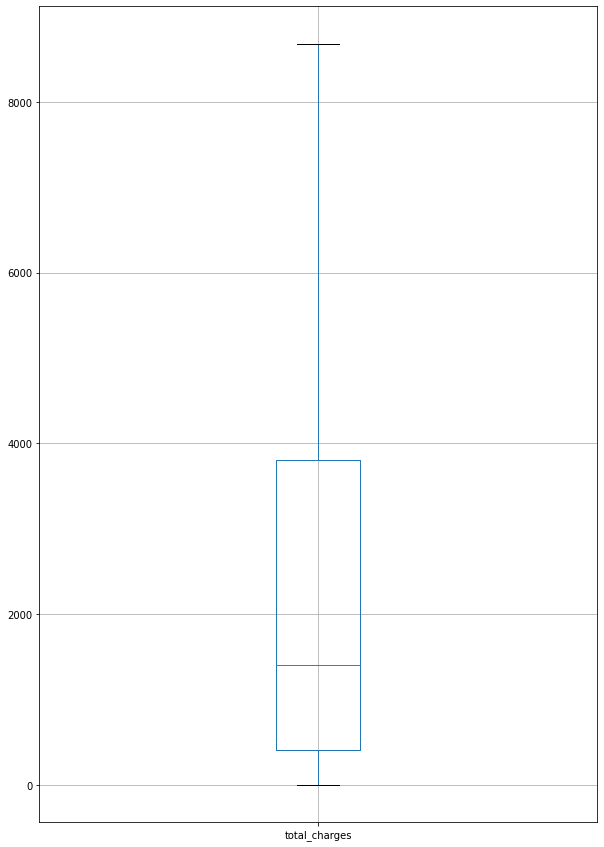

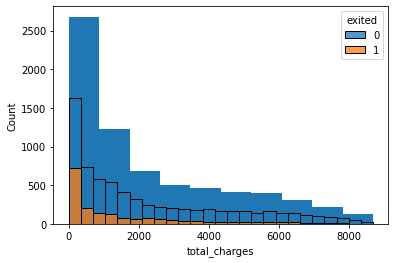

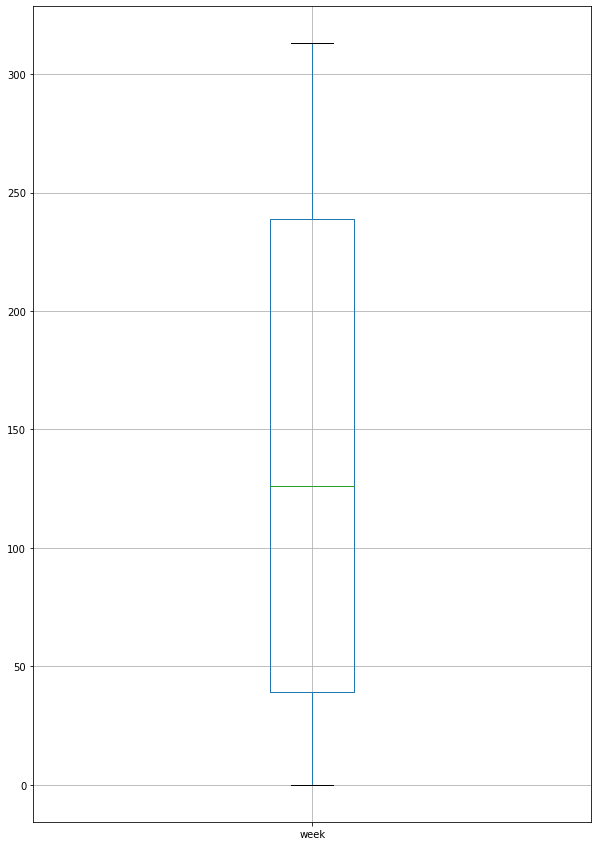

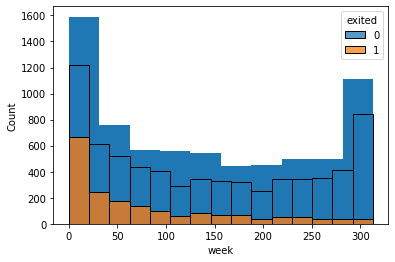

In [58]:
num_cols=['monthly_charges', 'total_charges', 'week']
for row in num_cols:
    data.boxplot(column=row, figsize=(10,15))
    plt.show()
    plt.hist(data[row])
    sns.histplot(data, x=row, hue = 'exited', multiple = 'stack')
    plt.show()

Выбросы и анмоальные значения отсутствуют. Мы видим, что среди тех, кто покинул компанию, многие имели высокие ежемесячные платежи, так же много людей покидало компанию в первые 25 недель

Теперь взглянем на категориальные признаки

Распределение признака: type
Month-to-month    3853
Two year          1695
One year          1473
Name: type, dtype: int64 



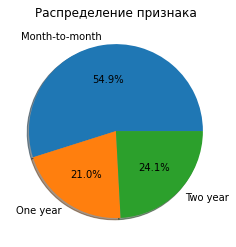

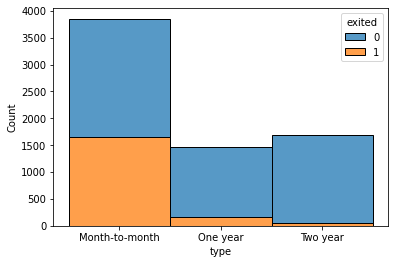

Распределение признака: paper_less_billing
Yes    4161
No     2860
Name: paper_less_billing, dtype: int64 



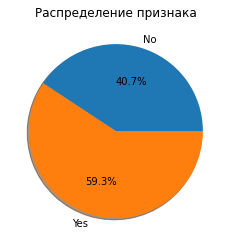

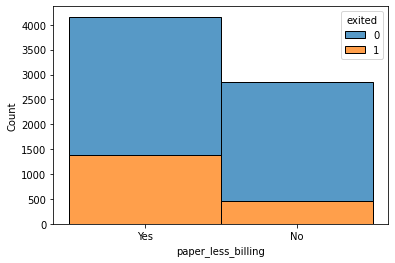

Распределение признака: payment_method
Electronic check             2359
Mailed check                 1596
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_method, dtype: int64 



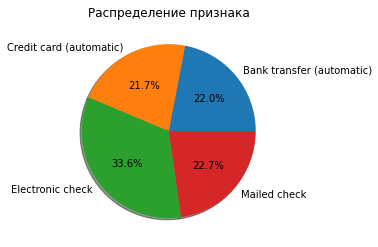

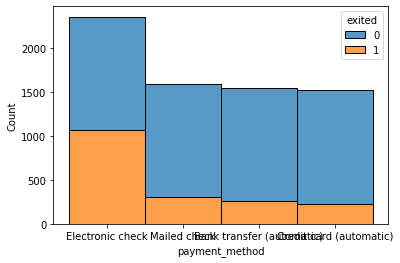

Распределение признака: gender
Male      3541
Female    3480
Name: gender, dtype: int64 



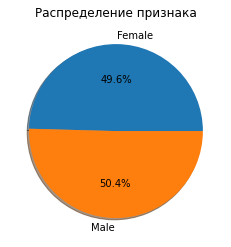

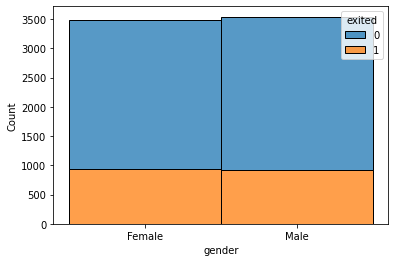

Распределение признака: senior_citizen
False    5880
True     1141
Name: senior_citizen, dtype: int64 



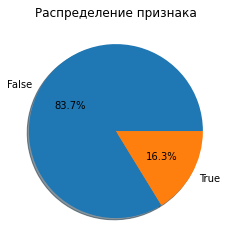

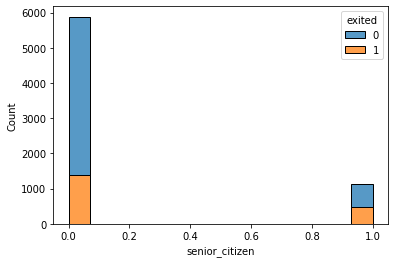

Распределение признака: partner
No     3619
Yes    3402
Name: partner, dtype: int64 



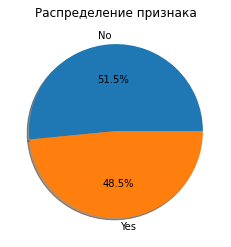

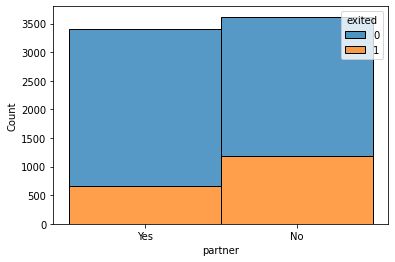

Распределение признака: dependents
No     4911
Yes    2110
Name: dependents, dtype: int64 



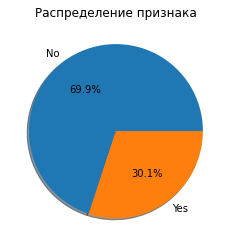

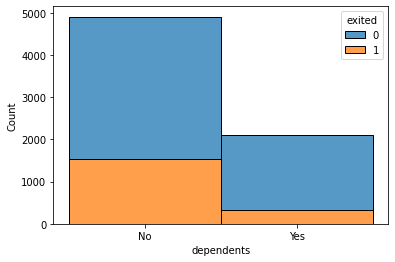

Распределение признака: internet_service
Fiber optic    3090
DSL            2419
No             1512
Name: internet_service, dtype: int64 



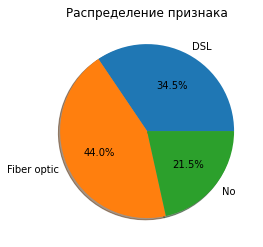

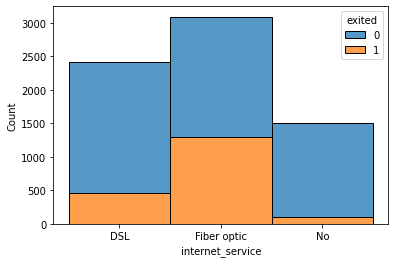

Распределение признака: online_security
No     5002
Yes    2019
Name: online_security, dtype: int64 



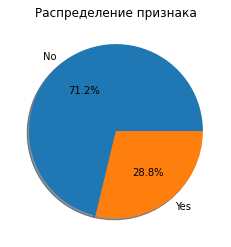

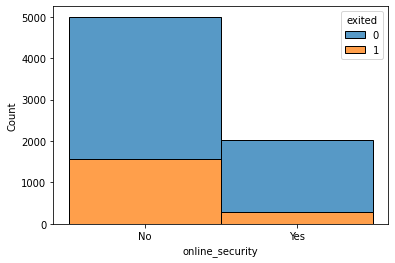

Распределение признака: online_backup
No     4592
Yes    2429
Name: online_backup, dtype: int64 



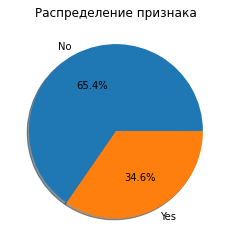

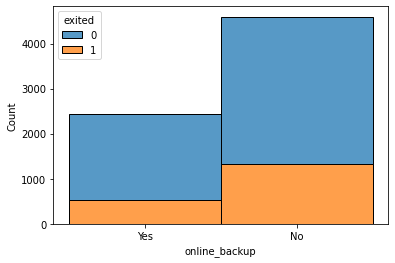

Распределение признака: device_protection
No     4599
Yes    2422
Name: device_protection, dtype: int64 



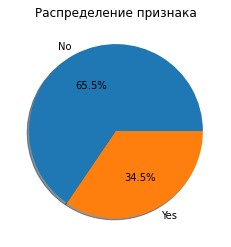

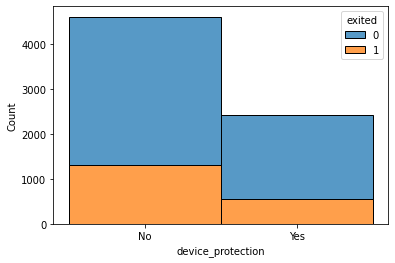

Распределение признака: tech_support
No     4977
Yes    2044
Name: tech_support, dtype: int64 



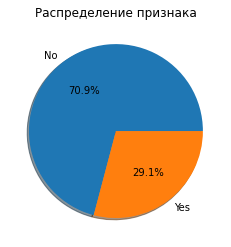

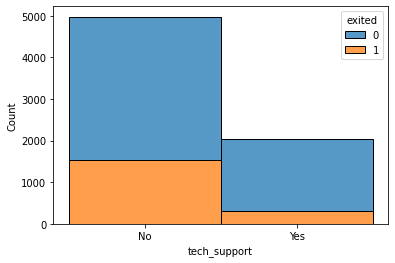

Распределение признака: streaming_tv
No     4314
Yes    2707
Name: streaming_tv, dtype: int64 



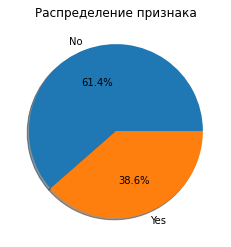

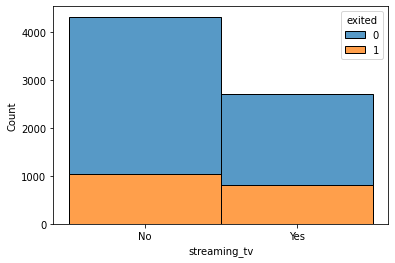

Распределение признака: streaming_movies
No     4289
Yes    2732
Name: streaming_movies, dtype: int64 



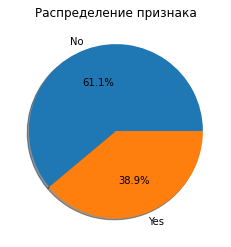

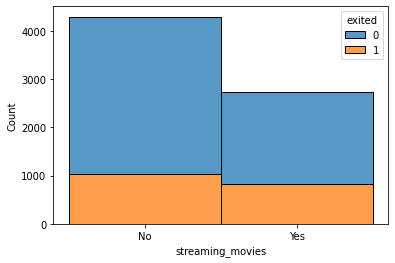

Распределение признака: multiple_lines
No          3368
Yes         2971
No phone     682
Name: multiple_lines, dtype: int64 



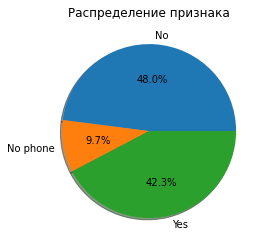

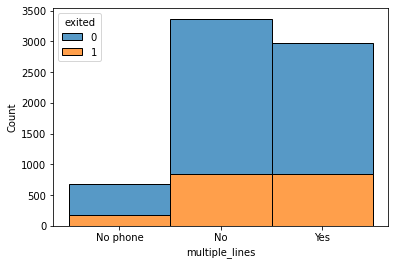

In [61]:
cat_cols = ['type',
             'paper_less_billing',
             'payment_method',
             'gender',
             'senior_citizen',
             'partner',
             'dependents',
             'internet_service',
             'online_security',
             'online_backup',
             'device_protection',
             'tech_support',
             'streaming_tv',
             'streaming_movies',
             'multiple_lines']

for row in cat_cols:
    print('Распределение признака:', row)  
    print(data[row].value_counts(), '\n')
    (
        data.groupby(row)['type'].count()
        .plot(ylabel = '', kind = 'pie', autopct='%1.1f%%', shadow=True, title = 'Распределение признака')
    )
    
    plt.show()
    sns.histplot(data, x=row, hue = 'exited', multiple = 'stack')
    plt.show()

Явный дисбаланс мы наблюдаем только в признаке `senior_citizen`, видимо пенсионеры реже пользуются услугами связи. Люди с ежемесячными платежами чсаще уходят из компании, чем люди, которые платят один или два раза в год

Проверим распределение целевого признака

Распределение целевого признака:
0    5164
1    1857
Name: exited, dtype: int64 



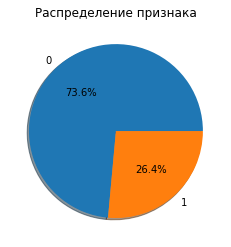

In [62]:
print('Распределение целевого признака:')  
print(data['exited'].value_counts(), '\n')
(
    data.groupby('exited')['type'].count()
    .plot(ylabel = '', kind = 'pie', autopct='%1.1f%%', shadow=True, title = 'Распределение признака')
)
plt.show()

**В Целевыом признаке наблюдается дисбаланс**

## 1.4 Исследование корреляции признаков

interval columns not set, guessing: ['monthly_charges', 'total_charges', 'month', 'exited']


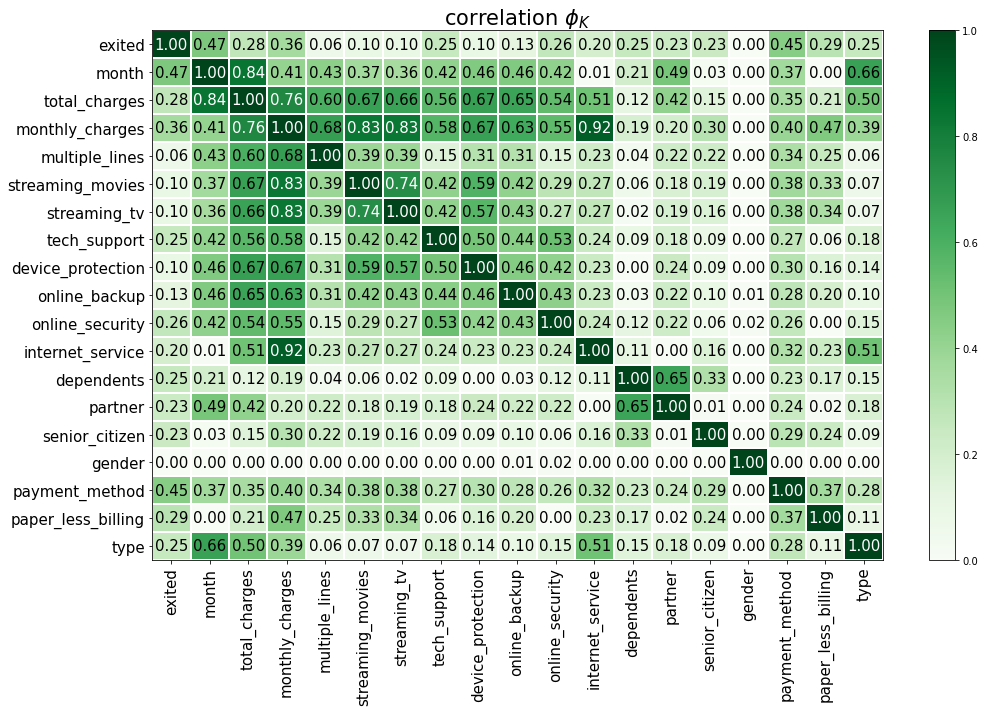

In [49]:
phik_overview = data.phik_matrix()
phik_overview.round(2)
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15, 10))
plt.tight_layout()

Мы видим отсутствие корреляции между признаком `gender` и целевым признаком. Удалим этот столбцец. Кроме того есть очень высокая корреляция между столбцами `monthly_charges` и `internet_service`, значит эти столбцы зависят друг от друга, удалим один из них. Так же есть коллинеарность между признаками `month` и `total_charges` ,что логично ,потому что общая сумма выплат зависит от количества месяцев, в течении которых абонент пользуется услугами. Удалим столбец `total_charges`

In [63]:
data=data.drop(['gender', 'total_charges'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7021 entries, 0 to 7020
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   type                7021 non-null   object 
 1   paper_less_billing  7021 non-null   object 
 2   payment_method      7021 non-null   object 
 3   senior_citizen      7021 non-null   bool   
 4   partner             7021 non-null   object 
 5   dependents          7021 non-null   object 
 6   internet_service    7021 non-null   object 
 7   online_security     7021 non-null   object 
 8   online_backup       7021 non-null   object 
 9   device_protection   7021 non-null   object 
 10  tech_support        7021 non-null   object 
 11  streaming_tv        7021 non-null   object 
 12  streaming_movies    7021 non-null   object 
 13  multiple_lines      7021 non-null   object 
 14  monthly_charges     7021 non-null   float64
 15  week                7021 non-null   int64  
 16  exited

**Мы обработали и исследовали данные, теперь мы готовы к их обучению и построению моделей**

# 2 Подготовка данных

##  2.1 Выделение целевого признака

**Создадим переменную `features` со всеми признаками, кроме `exited`. Создадим переменную target с целевым признаком `exited`**

In [64]:
features = data.drop(['exited'], axis=1)
target = data['exited']

##  2.2 Создание тренировочного и тестового датасета

In [65]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=270323, stratify = target)

# 3. Построение моделей

напишем код для кодирования и стандартизации признаков для логистической регрессии и случайного леса

In [73]:
#создадим новый списокс категориальными признаками
cat_cols = ['type',
             'paper_less_billing',
             'payment_method',
             'senior_citizen',
             'partner',
             'dependents',
            'internet_service',
             'online_security',
             'online_backup',
             'device_protection',
             'tech_support',
             'streaming_tv',
             'streaming_movies',
            'multiple_lines'
             ]
num_cols=['monthly_charges', 'week']

In [74]:
transformer_log = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='error'),
        cat_cols
    ),
    (
        StandardScaler(), 
        num_cols
    )
)
    


## 3.1 Логистическая регрессия

In [75]:
model_lr = LogisticRegression(class_weight='balanced', random_state=270323)

In [76]:
%%time
pipline_lr = make_pipeline(transformer_log, model_lr)
parametrs_lr = { 'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              'logisticregression__max_iter': range (6,15,2),
              }
lr = GridSearchCV(pipline_lr, param_grid=parametrs_lr, cv=3, scoring='roc_auc')
lr.fit(features_train, target_train)
auc_roc_lr = lr.best_score_
auc_roc_lr_params=lr.best_params_
# лучшее значение auc_roc на кросс-валидации
print(f'best_score: {auc_roc_lr}')
# лучшие гиперпараметры
print(f'best_params: {auc_roc_lr_params}')

best_score: 0.840898399545947
best_params: {'logisticregression__C': 0.1, 'logisticregression__max_iter': 14}
CPU times: user 22.1 s, sys: 22.5 s, total: 44.6 s
Wall time: 44.8 s


## 3.2 Случайный лес

In [77]:
%%time
model_rf = RandomForestClassifier(class_weight='balanced', random_state=270323)
pipline_rf =  make_pipeline(transformer_log, model_rf)
grid = {'randomforestclassifier__n_estimators':[10,20,30,40,50,60,70,80,90,100],
        'randomforestclassifier__max_depth': [5,6,7,8,9]}
rf = lr = GridSearchCV(pipline_rf, param_grid=grid, cv=3, scoring='roc_auc')
rf.fit(features_train, target_train)
auc_roc_rf = rf.best_score_
auc_roc_rf_params=rf.best_params_
# лучшее значение auc_roc на кросс-валидации
print(f'best_score: {auc_roc_rf}')
# лучшие гиперпараметры
print(f'best_params: {auc_roc_rf_params}')

best_score: 0.8471077018281136
best_params: {'randomforestclassifier__max_depth': 8, 'randomforestclassifier__n_estimators': 20}
CPU times: user 29.6 s, sys: 0 ns, total: 29.6 s
Wall time: 29.6 s


##  3.3 Модель градиентного бустинга CatBoost

In [78]:
%%time

train_dataset = Pool(features_train, target_train, cat_features=cat_cols) 
test_dataset = Pool(features_test, target_test, cat_features=cat_cols)
model_cat = CatBoostClassifier(random_state=270323, verbose=200, 
                               eval_metric='AUC:hints=skip_train~false', auto_class_weights = 'Balanced')
grid_cat = {'iterations': [100, 150, 200, 300],
        'learning_rate': [0.2, 0.3, 0.4, 0.5],
        'depth': [2, 4, 6, 8],
         'l2_leaf_reg': [3,5,7,9] }
model_cat.grid_search(grid_cat, train_dataset, cv=5)

model_cat_auc = model_cat.get_best_score()
print(model_cat_auc)

0:	learn: 0.7296673	test: 0.7139139	best: 0.7139139 (0)	total: 51.2ms	remaining: 5.07s
99:	learn: 0.8642397	test: 0.8573676	best: 0.8580380 (83)	total: 369ms	remaining: 0us

bestTest = 0.8580380232
bestIteration = 83

0:	loss: 0.8580380	best: 0.8580380 (0)	total: 878ms	remaining: 3m 43s
0:	learn: 0.7296673	test: 0.7139139	best: 0.7139139 (0)	total: 3.55ms	remaining: 352ms
99:	learn: 0.8707825	test: 0.8596279	best: 0.8600445 (93)	total: 327ms	remaining: 0us

bestTest = 0.860044536
bestIteration = 93

1:	loss: 0.8600445	best: 0.8600445 (1)	total: 1.21s	remaining: 2m 33s
0:	learn: 0.7296673	test: 0.7139139	best: 0.7139139 (0)	total: 3.34ms	remaining: 331ms
99:	learn: 0.8760635	test: 0.8544177	best: 0.8560507 (68)	total: 316ms	remaining: 0us

bestTest = 0.8560506656
bestIteration = 68

2:	loss: 0.8560507	best: 0.8600445 (1)	total: 1.53s	remaining: 2m 8s
0:	learn: 0.7296673	test: 0.7139139	best: 0.7139139 (0)	total: 2.97ms	remaining: 294ms
99:	learn: 0.8824734	test: 0.8607820	best: 0.860839

In [79]:
# Вывыдем на экран значения лучшие параметры модели
model_cat_auc = model_cat.get_best_score()
model_cat_best = model_cat.get_params()
print(model_cat_auc)
print(model_cat_best)

{'learn': {'Logloss': 0.4024820776302935, 'AUC': 0.8971919255367747}}
{'verbose': 200, 'auto_class_weights': 'Balanced', 'eval_metric': 'AUC:hints=skip_train~false', 'random_state': 270323, 'depth': 2, 'l2_leaf_reg': 3, 'iterations': 300, 'learning_rate': 0.4}


In [80]:
# Сохраним значение метрики roc-auc
model_cat_auc = model_cat_auc['learn']['AUC']
print(model_cat_auc)

0.8971919255367747


## 3.4 Модель LightGBM

In [81]:
%%time
for i in cat_cols:
    features_train[i] = features_train[i].astype('category')
model_lgbm = lgb.LGBMClassifier(n_estimators=1000, class_weight='balanced', random_state=270323) 
grid_lgbm = {'num_leaves':[11, 50],
        'learning_rate': [0.3, 0.4]}
model_lgbm = GridSearchCV(model_lgbm, grid_lgbm, scoring='roc_auc', verbose=10, cv=3)
model_lgbm.fit(features_train, target_train, categorical_feature=cat_cols)
auc_roc_lgbm = model_lgbm.best_score_
auc_roc_lgbm_params=model_lgbm.best_params_
# лучшее значение auc_roc на кросс-валидации
print(f'best_score: {auc_roc_lgbm}')
# лучшие гиперпараметры
print(f'best_params: {auc_roc_lgbm_params}')

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START learning_rate=0.3, num_leaves=11............................
[CV 1/3; 1/4] END ..........learning_rate=0.3, num_leaves=11; total time=   4.1s
[CV 2/3; 1/4] START learning_rate=0.3, num_leaves=11............................
[CV 2/3; 1/4] END ..........learning_rate=0.3, num_leaves=11; total time=   4.4s
[CV 3/3; 1/4] START learning_rate=0.3, num_leaves=11............................
[CV 3/3; 1/4] END ..........learning_rate=0.3, num_leaves=11; total time=   4.1s
[CV 1/3; 2/4] START learning_rate=0.3, num_leaves=50............................
[CV 1/3; 2/4] END ..........learning_rate=0.3, num_leaves=50; total time=  13.2s
[CV 2/3; 2/4] START learning_rate=0.3, num_leaves=50............................
[CV 2/3; 2/4] END ..........learning_rate=0.3, num_leaves=50; total time=  14.3s
[CV 3/3; 2/4] START learning_rate=0.3, num_leaves=50............................
[CV 3/3; 2/4] END ..........learning_rate=0.3, nu

## 3.5 Сравнение результатов модели, выбор наилучшей

Создадим таблицу с результатами работы наших моделей

In [82]:
columns=['roc_auc модели', 'парамтеры лучшей модели']
index = ['LinearRegression', 'RandomForestRegressor', 'CatBoostRegressor', 'LightGBM']
data = [
    [auc_roc_lr, auc_roc_lr_params],
    [auc_roc_rf, auc_roc_rf_params],
    [model_cat_auc, model_cat_best],
    [auc_roc_lgbm, auc_roc_lgbm_params]
]

final_tabl = pd.DataFrame(data = data, columns = columns, index=index)

In [83]:
final_tabl

,roc_auc модели,парамтеры лучшей модели
LinearRegression,0.840898,"{'logisticregression__C': 0.1, 'logisticregres..."
RandomForestRegressor,0.847108,"{'randomforestclassifier__max_depth': 8, 'rand..."
CatBoostRegressor,0.897192,"{'verbose': 200, 'auto_class_weights': 'Balanc..."
LightGBM,0.812751,"{'learning_rate': 0.3, 'num_leaves': 11}"


**На тренировочный выборке лучший результат метрики `roc_auc` показала модель Градиентного бустинга CatBoost. Метрика roc_auc = 0,897 на кросс-валидации, парматеры лучше модели: 'depth': 2, 'l2_leaf_reg': 3, 'iterations': 300, 'learning_rate': 0.4  Её и применим к нашей тестовой выборке**


# 4. Тестирование лучшей модели

## 4.1 Проверка лучшей модели на тестовой выборке

In [84]:
model_cat_best=CatBoostClassifier(random_state=270323, verbose=200, eval_metric='AUC:hints=skip_train~false', 
                                  depth=2, iterations=200, learning_rate=0.4, l2_leaf_reg=3)
model_cat_best.fit(features_train,target_train, cat_features=cat_cols)
predict=model_cat_best.predict(features_test)
probabilities_valid = model_cat_best.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc = roc_auc_score(target_test, probabilities_one_valid)

0:	learn: 0.7172482	total: 4.41ms	remaining: 877ms
199:	learn: 0.8895924	total: 861ms	remaining: 0us


In [85]:
print(roc_auc)

0.8583057542436212


**Результат метрики roc_auc=0.858, что соответствует условию задачи**

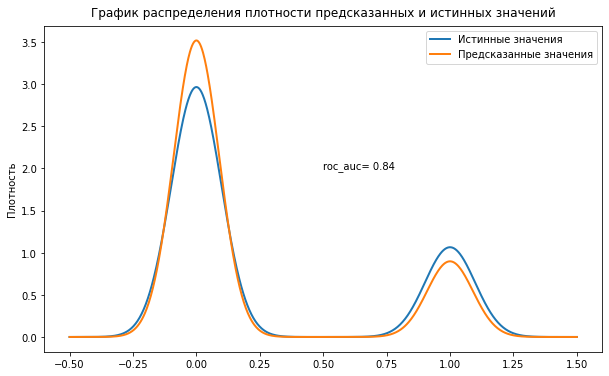

In [65]:
plt.figure(figsize=(10,6))
target_test.plot(kind='kde', linewidth=2)
pd.Series(predict).plot(kind='kde',linewidth=2)
plt.title('График распределения плотности предсказанных и истинных значений', y=1.01)
plt.legend(['Истинные значения','Предсказанные значения'])
plt.text(0.5,2,'roc_auc= {:.2f}'.format(roc_auc))
plt.xlabel('')
plt.ylabel('Плотность')
plt.show()

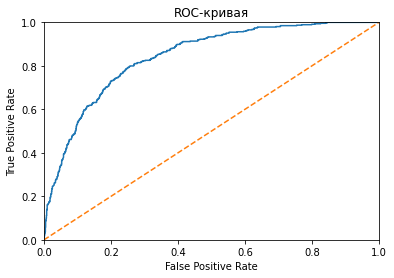

In [66]:
# Построим Roc-кривую
fpr, tpr, thresholds = roc_curve(target_test, probabilities_valid[:, 1])
plt.figure()
plt.plot(fpr, tpr)
plt.title("ROC-кривая")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.show()

**Положение Roc-кривой нашей модели над roc-кривой случайной модели, а так же высокое значение параметра auc-roc говорит нам о высоком качестве нашей модели**

Изучим важность признаков

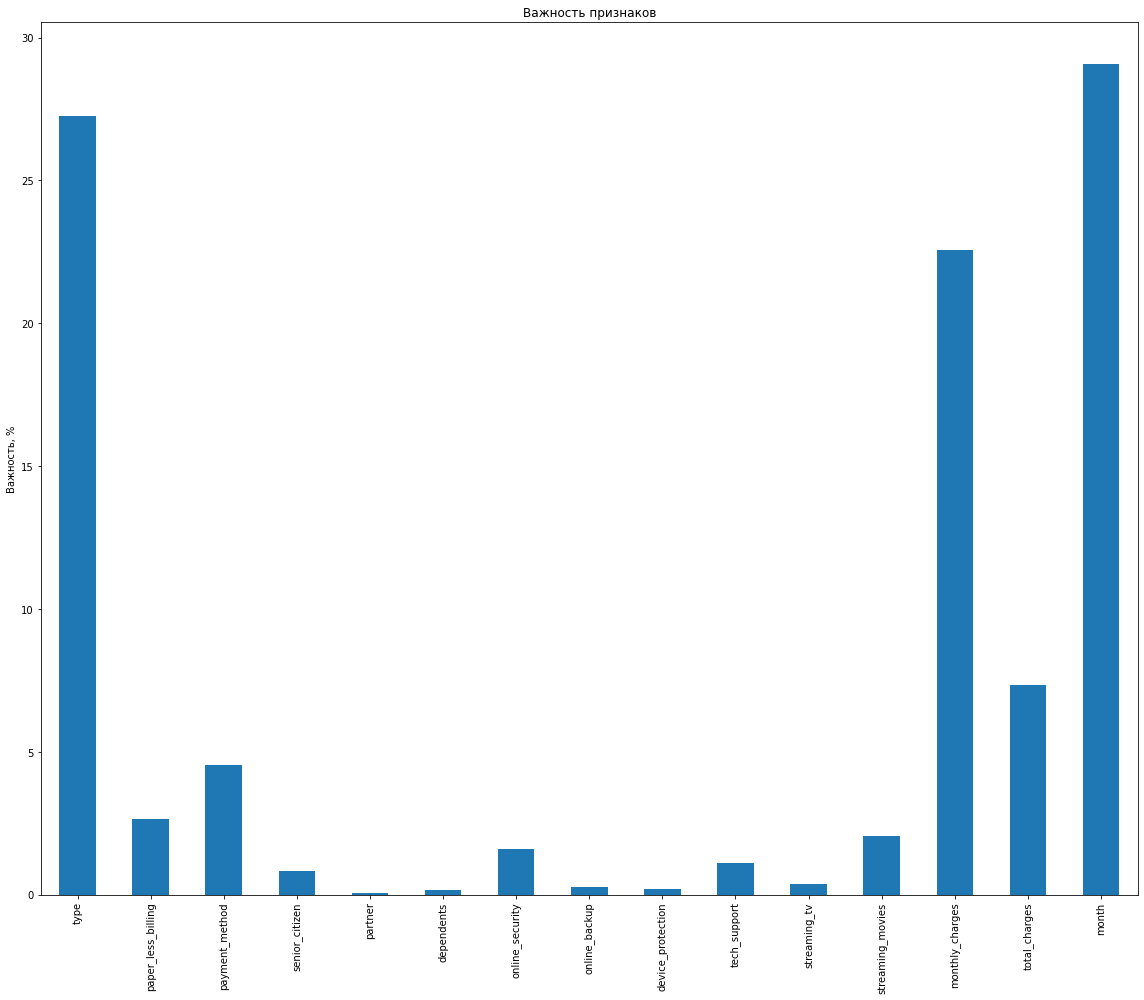

In [67]:
cat_important = pd.Series(model_cat_best.get_feature_importance(),
                        features_test.columns)
fig, ax = plt.subplots(figsize=(16,14))
cat_important.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность, %')
fig.tight_layout()

Мы видим, что самыми важными признаками стали платеж клента, тип платежа и время, которое клиент пользуется услугами компании

## 4.2 Проверка модели на адекатность

**Так как у нас явный перекос в пользу 0, то для проверки на адекватность сравним точность нашей модели с baseline моделью, которая всегда предсказывает наиболее частовстречающийся класс**

In [ ]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=0)
dummy_clf.fit(features_train, target_train)
dummy_clf.predict_proba(features_test)[:,1]
result_dummy = roc_auc_score(target_test, dummy_clf.predict_proba(features_test)[:,1])
print("Метрика roc_auc для константной модели:", result_dummy)


Метрика нашей модели получилась выше, чем у константной, следовательно тест на адекватность пройден

# Выводы по проекту

 - В данном проекте был проведен анализ базы данных клиентов компании и создание модели, которая будет предсказывать уход клиента из компании
 - Были загружены и обработаны 4 датасета с данными
 - Данные были сгруппированы в один датаест
 - Была произведена предобработка данных
 - В данные были добавлены столбцы `month` - количество месяцев, в течении которых клиент пользуется(пользовался) услугами компании, `exited` - целевой признак, факту ухода клиента из компании
 - Был проведен исследовательский анализ данных
 - Было проведено исследование корреляции признаков, в результате которой были удалены столбцы `gender`, `multiple_lines`, `internet_service`
 - Была проведена подготовка данных к обучению модели, выделение целевого признака, создание тренирвоочного и тестового датасетов
 - В ходе выполнения проекта были обучены 4 модели: LogisticRegression, RandomForestClassifier, CatBoostClassifier и LightGBM. Лучший результат показала модель CatBoostClassifier
 - Проверили лучшую модель на тестовой выборке, результат метрики roc_auc = 0.858
 - Изучили важность признаков, получилось, что самыми важными признакми являются платеж клента, тип платежа и время, которое клиент пользуется услугами компании.

# Отчет по работе

 1. Признаки, которые использовались для обучения:
     - `exited` - целевой признак, факт ухода клиента из компании, если в столбец `end_date` был, пропуск, то `exited`=0, если стояла дата ухода, то `exited`=1
     - `week` - количество недель, в течении которого клиент пользуется услугами. Вычисляется как разница между столбцами `end_date` и `begin_date`. Пропуски в столбце `end_date` предварительно заполняются `2020-02-01` - дата актуальной информации о клиентах
     - `monthly_charges` - ежемесячные платежи
     - `type` - тип оплаты: ежемесячный, годовой и тд
     - `paper_less_billing` - безналичный расчет
     - `payment_method` - способ оплаты
     - `senior_citizen` - наличие пенсионного статуса по возрасту
     - `partner` - наличие скпруга(и)
     - `dependents` - наличие иждивенцев
     - `multiple_lines` - наличие возможности ведения параллельных линий во время звонка
     - `paperless_billing` - безналичный расчет
     - `device_protection` - антивирус
     - `internet_service` - пользование интернетом
     - `online_security` -  блокировка небезопасных сайтов 
     - `online_backup` - Облачное хранилище файлов для резервного копирования данных
     - `tech_support` - Выделенная линия технической поддержки
     - `streaming_tv` - Стриминговое телевидение
     - `streaming_movies` - каталог фильмов
 2. Проект выполнен согласно плану, отличий от исходного плана нет
 3. В предобработке данных были выполнены следующие шаги:
     - После сгенерирования целевого признака и столбца `week` были удалены столбцы `begin_date`, `end_date`, `customer_id`
     - Пропуски в столбце `multiple_lines` заменены на `No phone`
     - Пропуски в остальных стлобцах заменены на `No`
     - Удалены явные дубликаты
     - После исследование корреляции удалены столбцы `genre` и `total_charges`
 4. При выполнения проекта трудностей не возникло
 5. Все шаги выполнения проекта являются важными, так как от правильности их выполнения и выводов, которые делаются в результате зависит показатели итоговой метрики
 6. Тестирование происходило на модели `CatBoostClassifier` со следующими гипперпараметрами:
     - ` depth`: 2
     - `l2_leaf_reg`: 3
     - `iterations` : 300
     - `learning_rate`: 0.4
 7. Результат метрики ROC-AUC лучше модели на тестовой вобрке: **0,858**
 8. Размер тестовой быборки 0,25. Параметр `random_state` = 270323
     